In [ ]:
%pip install -q --no-warn-conflicts malariagen_data

In [ ]:
import pandas as pd
import numpy as np
import malariagen_data
import allel
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [ ]:
# my own input
import dask.dataframe as dd

In [ ]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib_venn as venn
import seaborn as sns

sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 150
sns.set_context('paper', font_scale=.6)
sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')
rcParams = plt.rcParams


base_font_size = 7
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = 10
rcParams['axes.linewidth'] = .5
rcParams['lines.linewidth'] = .5
rcParams['patch.linewidth'] = .5
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
rcParams['savefig.format' ] = 'png'
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.max_open_warning'] = 1000
rcParams['figure.dpi'] = 120
rcParams['figure.facecolor'] = 'w'

In [ ]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive/"
os.makedirs(results_dir, exist_ok=True)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
## Let's acces to the data
ag3 = malariagen_data.Ag3()

##Defining sample sets
sets = ['AG1000G-AO', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-BF-C', 'AG1000G-CD',
        'AG1000G-CF','AG1000G-CI', 'AG1000G-CM-A', 'AG1000G-CM-B', 'AG1000G-CM-C',
        'AG1000G-FR', 'AG1000G-GA-A', 'AG1000G-GH', 'AG1000G-GM-A', 'AG1000G-GM-B',
        'AG1000G-GM-C', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-GQ', 'AG1000G-GW',
        'AG1000G-KE', 'AG1000G-ML-A', 'AG1000G-ML-B', 'AG1000G-MW', 'AG1000G-MZ',
        'AG1000G-TZ', 'AG1000G-UG']

df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
pops = df_samples.location.unique()

#To access to the genotypes within the 2L chromosomes
chrom2L_gt = ag3.snp_calls(region="2L", sample_sets=sets)

# SNP position in the 2L chromosomes
snps_pos = allel.SortedIndex(chrom2L_gt['variant_position'].values)
loc_region = snps_pos.locate_range(3744500, 3748000)

#To the genomics dataset within the HPPD region
Target_region = chrom2L_gt.sel(variants=loc_region)

# To filter the SNP dataset and warp the dataset to GT array
filt = 'gamb_colu_arab'
filt_val = Target_region[f"variant_filter_pass_{filt}"].values
gt_filtered = allel.GenotypeDaskArray(Target_region["call_genotype"][filt_val].data)

## Warp gt to array and count allel
with ProgressBar():
    gt_filtered_arr = allel.GenotypeArray(gt_filtered)
    ac = gt_filtered.count_alleles(max_allele=3).compute()


[########################################] | 100% Completed | 4.61 s
[########################################] | 100% Completed | 4.46 s


In [ ]:
chrom2L_gt['variant_allele'].values

array([[b'A', b'C', b'T', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       ...,
       [b'A', b'C', b'T', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'A', b'C', b'T', b'G']], dtype='|S1')

In [ ]:
filt_val

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
gt_filtered

<GenotypeDaskArray shape=(3175, 2784, 2) dtype=int8>

In [ ]:
gt_filtered_arr

<GenotypeArray shape=(3175, 2784, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [ ]:
ac

<AlleleCountsArray shape=(3175, 4) dtype=int32>
5568    0    0    0
5566    0    0    0
5567    0    1    0
...
5543    3   22    0
5568    0    0    0
5553    0    0   15

In [ ]:
# To get the variants positions within the target region in hppd
is_variant = ac.is_variant()
pos_df = Target_region['variant_position'][filt_val][is_variant].compute()
pos = allel.SortedIndex(pos_df["variant_position"].values)
reg_hppd = pos.locate_range(3745921, 3747552)
pos_hppd = pos[reg_hppd]
pos_filt = allel.SortedIndex(Target_region['variant_position'][filt_val].values)

In [ ]:
is_variant

array([False, False,  True, ...,  True, False,  True])

In [ ]:
pos_df

<xarray.DataArray 'variant_position' (variants: 1506)>
array([3744502, 3744503, 3744504, ..., 3747997, 3747998, 3748000],
      dtype=int32)
Coordinates:
    variant_position  (variants) int32 3744502 3744503 ... 3747998 3748000
    variant_contig    (variants) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: variants

In [ ]:
# HPPD region
hppd_region = ('2L', 3745921, 3747552)

## reference genome
df_geneset = ag3.geneset().set_index("ID")
#df_geneset

## let's access to the reference transcript of the gene AGAP004802
df_geneset.query("Parent == 'AGAP004802'")

## let's choose a transcripts
transcrit_id = ['AGAP004802-RA']
#transcrit_id

hppd_genset = df_geneset.loc[(df_geneset.index == 'AGAP004802')|(df_geneset.index.isin(transcrit_id))|
                           (df_geneset.Parent.isin(transcrit_id))]
gene_id = list(hppd_genset.index)
hppd_genset.insert(loc=8, column='gene_id', value=gene_id)
hppd_genset.fillna(0)
hppd_genset

,contig,source,type,start,end,score,strand,phase,gene_id,Parent,Name,description
ID,,,,,,,,,,,,
AGAP004802,2L,VectorBase,gene,3745921,3747552,NaN,+,NaN,AGAP004802,NaN,NaN,4-hydroxyphenylpyruvate dioxygenase [Source:Un...
AGAP004802-RA,2L,VectorBase,mRNA,3745921,3747552,NaN,+,NaN,AGAP004802-RA,AGAP004802,NaN,NaN
NaN,2L,VectorBase,five_prime_UTR,3745921,3746101,NaN,+,NaN,NaN,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3745921,3746104,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E1,NaN
AGAP004802-PA,2L,VectorBase,CDS,3746102,3746104,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3746202,3747269,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E2,NaN
AGAP004802-PA,2L,VectorBase,CDS,3746202,3747269,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
AGAP004802-PA,2L,VectorBase,CDS,3747338,3747412,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3747338,3747552,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E3,NaN


In [ ]:
gene_id

['AGAP004802',
 'AGAP004802-RA',
 nan,
 nan,
 'AGAP004802-PA',
 nan,
 'AGAP004802-PA',
 'AGAP004802-PA',
 nan,
 nan]

In [ ]:
hppd_genset

,contig,source,type,start,end,score,strand,phase,gene_id,Parent,Name,description
ID,,,,,,,,,,,,
AGAP004802,2L,VectorBase,gene,3745921,3747552,NaN,+,NaN,AGAP004802,NaN,NaN,4-hydroxyphenylpyruvate dioxygenase [Source:Un...
AGAP004802-RA,2L,VectorBase,mRNA,3745921,3747552,NaN,+,NaN,AGAP004802-RA,AGAP004802,NaN,NaN
NaN,2L,VectorBase,five_prime_UTR,3745921,3746101,NaN,+,NaN,NaN,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3745921,3746104,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E1,NaN
AGAP004802-PA,2L,VectorBase,CDS,3746102,3746104,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3746202,3747269,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E2,NaN
AGAP004802-PA,2L,VectorBase,CDS,3746202,3747269,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
AGAP004802-PA,2L,VectorBase,CDS,3747338,3747412,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3747338,3747552,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E3,NaN


In [ ]:
transcrit_id

['AGAP004802-RA']

In [ ]:
# Import conservation score data
C_score = pd.read_table('/content/drive/MyDrive/hppd_Cs_results.tsv')
C_score

,chromosome,pos,Cs
0,2L,3745921,0.056492
1,2L,3745922,0.054833
2,2L,3745923,0.072352
3,2L,3745924,0.049789
4,2L,3745925,0.194774
...,...,...,...
1626,2L,3747547,0.007022
1627,2L,3747548,0.002024
1628,2L,3747549,0.030302
1629,2L,3747550,0.008787


In [ ]:
# Cs score statistics
from statistics import mean, median
print('Conservation score in the whole gene')
print(f'Score min: {min(C_score.Cs)} \nScore median: {median(C_score.Cs)} \nScore mean: {mean(C_score.Cs)}',
      f'\nScore max: {max(C_score.Cs)}, pos: {list(C_score.query("Cs > 0.8").pos)}')
print('\n',
      f'\nScore max: {max(C_score.Cs)}, pos: {list(C_score.query("Cs > 0.8").pos)}')

Conservation score in the whole gene
Score min: 0.0001562751 
Score median: 0.15734142 
Score mean: 0.26764503039688536 
Score max: 0.8423878, pos: [3746466, 3746467, 3746469, 3746472, 3746473, 3746475, 3746480, 3746481, 3746820, 3746821, 3746854, 3746856, 3746863, 3746872, 3746875, 3746885, 3746891, 3746895, 3746902, 3747177, 3747180, 3747192, 3747198, 3747200, 3747206, 3747208, 3747363, 3747398, 3747399, 3747401, 3747402, 3747409]

 
Score max: 0.8423878, pos: [3746466, 3746467, 3746469, 3746472, 3746473, 3746475, 3746480, 3746481, 3746820, 3746821, 3746854, 3746856, 3746863, 3746872, 3746875, 3746885, 3746891, 3746895, 3746902, 3747177, 3747180, 3747192, 3747198, 3747200, 3747206, 3747208, 3747363, 3747398, 3747399, 3747401, 3747402, 3747409]


In [ ]:
# Define exon location in the gene
UTR_5 = ('2L', 3745921, 3746101)
Exon_1 = ('2L', 3746102, 3746104)
Exon_2 = ('2L', 3746202, 3747269)
Exon_3 = ('2L', 3747338, 3747412)
UTR_3 = ('2L', 3747413, 3747552)

exon_loc = [UTR_5, Exon_1, Exon_2, Exon_3, UTR_3]

# Extract exon conservation score
df_list = list()
for loc in exon_loc:
    print(loc[1], loc[2])
    df_list.append(C_score.query(f'pos >= {loc[1]} and pos <= {loc[2]}'))
exon_Cscore = pd.concat(df_list)
exon_Cscore

3745921 3746101
3746102 3746104
3746202 3747269
3747338 3747412
3747413 3747552


,chromosome,pos,Cs
0,2L,3745921,0.056492
1,2L,3745922,0.054833
2,2L,3745923,0.072352
3,2L,3745924,0.049789
4,2L,3745925,0.194774
...,...,...,...
1626,2L,3747547,0.007022
1627,2L,3747548,0.002024
1628,2L,3747549,0.030302
1629,2L,3747550,0.008787


In [ ]:
df_list

[    chromosome      pos        Cs
 0           2L  3745921  0.056492
 1           2L  3745922  0.054833
 2           2L  3745923  0.072352
 3           2L  3745924  0.049789
 4           2L  3745925  0.194774
 ..         ...      ...       ...
 176         2L  3746097  0.033177
 177         2L  3746098  0.015240
 178         2L  3746099  0.017208
 179         2L  3746100  0.013205
 180         2L  3746101  0.042164
 
 [181 rows x 3 columns],
     chromosome      pos        Cs
 181         2L  3746102  0.047121
 182         2L  3746103  0.047153
 183         2L  3746104  0.059401,
      chromosome      pos        Cs
 281          2L  3746202  0.394665
 282          2L  3746203  0.504278
 283          2L  3746204  0.455556
 284          2L  3746205  0.436875
 285          2L  3746206  0.504278
 ...         ...      ...       ...
 1344         2L  3747265  0.594887
 1345         2L  3747266  0.088002
 1346         2L  3747267  0.594887
 1347         2L  3747268  0.657838
 1348         2L

In [ ]:
print('Conservation score in the exon region')
print(f'Score min: {min(exon_Cscore.Cs)} \nScore median: {median(exon_Cscore.Cs)}',
      f'\nScore max: {max(exon_Cscore.Cs)}, pos: {list(exon_Cscore.query("Cs > 0.8").pos)}')

Conservation score in the exon region
Score min: 0.0001562751 
Score median: 0.19384303 
Score max: 0.8423878, pos: [3746466, 3746467, 3746469, 3746472, 3746473, 3746475, 3746480, 3746481, 3746820, 3746821, 3746854, 3746856, 3746863, 3746872, 3746875, 3746885, 3746891, 3746895, 3746902, 3747177, 3747180, 3747192, 3747198, 3747200, 3747206, 3747208, 3747363, 3747398, 3747399, 3747401, 3747402, 3747409]


In [ ]:
## Compute all genotypes
hppd_gt = allel.GenotypeDaskArray(Target_region["call_genotype"][filt_val].data)

## To count the number of alleles
with ProgressBar():
    hppd_gt_arr = allel.GenotypeArray(hppd_gt)
    hppd_ac = hppd_gt_arr.count_alleles(max_allele=3)

## Genotypes by pop location
pops = df_samples.country.unique()
## genotypes pop by country
def subset_genotypes():
    global gt_country, ac_country
    gt_country, ac_country = {}, {}
    for idx in pops:
        loc_pop = df_samples[df_samples.country == idx].index.values
        gt_country[idx] = hppd_gt_arr.take(loc_pop, axis=1)
        ac_country[idx] = gt_country[idx].count_alleles(max_allele=3)
subset_genotypes()

[########################################] | 100% Completed | 2.97 s


In [ ]:
hppd_gt.compute()# to display dask.array value

<GenotypeArray shape=(3175, 2784, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [ ]:
type(hppd_gt)

allel.model.dask.GenotypeDaskArray

In [ ]:
allel.GenotypeArray?
allel.GenotypeDaskArray?

In [ ]:
## define exon position

UTR_5 = ('2L', 3745921, 3746101)
Exon_1 = ('2L', 3746102, 3746104)
Exon_2 = ('2L', 3746202, 3747269)
Exon_3 = ('2L', 3747338, 3747412)
UTR_3 = ('2L', 3747413, 3747552)

<ipython-input-66-d6ba8b1619c0>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


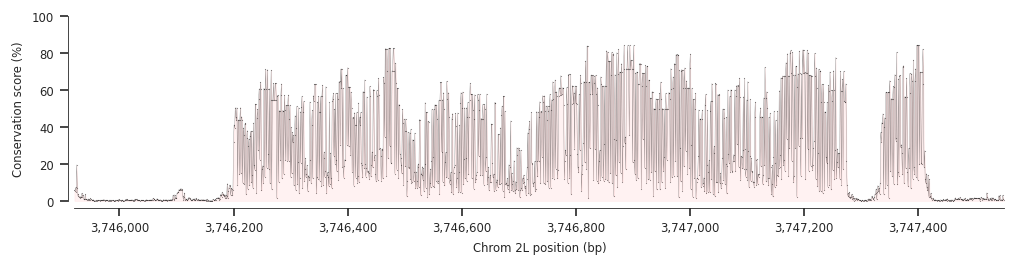

In [ ]:
def plot_Conservation_sore(loc=hppd_region, ylim=(0, 100), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2))
        sns.despine(ax=ax, offset=4)
    # plot cs
    pl = C_score.query(f'pos >= {loc[1]} and pos <= {loc[2]}')
    ax.fill_between(pl.pos, 0, pl.Cs * 100, color='r', alpha=.05)
    ax.plot(pl.pos, pl.Cs * 100 , linestyle='-', linewidth = .2, marker='o', markersize=.2, color='k', alpha=.5)
    ax.set_ylabel('Conservation score (%)')
    ax.set_xlabel(f'Chrom {loc[0]} position (bp)')
    # tidy up
    xlim = (loc[1], loc[2])
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

plot_Conservation_sore()

In [ ]:
UTR_5 = ('2L', 3745921, 3746101)
Exon_1 = ('2L', 3746102, 3746104)
Exon_2 = ('2L', 3746202, 3747269)
Exon_3 = ('2L', 3747338, 3747412)
UTR_3 = ('2L', 3747413, 3747552)

In [ ]:
exons = (Exon_1, Exon_2, Exon_3)
utrs = (UTR_3, UTR_5)

In [ ]:
def transcript_dataset(data, transcrit):
    'This function compute the dataset of each transcript'
    tab_list = []
    for idx in data.index:
        if idx == transcrit:
            val = data.index.get_loc(idx)
            tab_list.append(data[:1])
            tab_list.append(data[val:][:1])
            tab_list.append(data[val:].query(f"Parent == '{idx}'"))
    return pd.concat(tab_list)

hppd_RA = transcript_dataset(hppd_genset, 'AGAP004802-RA')

UTR_5 = ('2L', 3745921, 3746101)
loc_FE = ('2L', 3746102, 3746104) #Exon_1
loc_ = ('2L', 3746202, 3747269) #Exon_2
Exon_3 = ('2L', 3747338, 3747412)
UTR_3 = ('2L', 3747413, 3747552)

In [ ]:
hppd_RA

,contig,source,type,start,end,score,strand,phase,gene_id,Parent,Name,description
ID,,,,,,,,,,,,
AGAP004802,2L,VectorBase,gene,3745921,3747552,NaN,+,NaN,AGAP004802,NaN,NaN,4-hydroxyphenylpyruvate dioxygenase [Source:Un...
AGAP004802-RA,2L,VectorBase,mRNA,3745921,3747552,NaN,+,NaN,AGAP004802-RA,AGAP004802,NaN,NaN
NaN,2L,VectorBase,five_prime_UTR,3745921,3746101,NaN,+,NaN,NaN,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3745921,3746104,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E1,NaN
AGAP004802-PA,2L,VectorBase,CDS,3746102,3746104,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3746202,3747269,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E2,NaN
AGAP004802-PA,2L,VectorBase,CDS,3746202,3747269,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
AGAP004802-PA,2L,VectorBase,CDS,3747338,3747412,NaN,+,0.0,AGAP004802-PA,AGAP004802-RA,NaN,NaN
NaN,2L,VectorBase,exon,3747338,3747552,NaN,+,NaN,NaN,AGAP004802-RA,AGAP004802-RA-E3,NaN


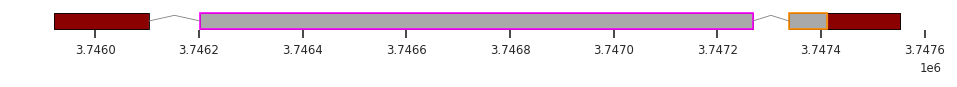

In [ ]:
def plot_transcripts(geneset, height=.5, label_transcripts=True, label_exons=False, label_exon_size=False,
                     label_codons=False, highlight_exons=None, label_cdss=False, highlight_color='red', ax=None,
                     title=None, xlim=None, exon_label='{}', spec_pos=None, region_name=None, int_reg=None,
                     int_reg_name=' ', include_transcripts=None):
    """Plot all transcripts for one or all genes overlapping a given region."""

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, .2))
    sns.despine(ax=ax, left=True, bottom=True)

    if title:
        ax.set_title(title, va='bottom')
    # find genes overlapping the given region
    genes = geneset.query("(type == 'gene')").sort_values('start')

    # iterate over genes
    for _, gene in genes.iterrows():

        # find child transcripts
        transcripts = geneset.query("(type == 'mRNA') and (Parent == %r)" % gene.gene_id).sort_values('gene_id')

        # iterate over transcripts
        for i, (_, transcript) in enumerate(transcripts.iterrows()):
            if include_transcripts is not None and transcript.gene_id not in include_transcripts:
                continue

            # coordinates for plotting the transcript
            if transcript.strand == '+':
                y = i
            else:
                y = -i - 1

            # annotate with transcript ID

            if xlim is not None:
                start, stop = xlim
                text_y = y + height + (height / 10)
                if label_transcripts == 'right':
                    text_x = min(stop, transcript.end)
                    ha = 'right'
                else:
                    text_x = max(start, transcript.start)
                    ha = 'left'
                if label_transcripts:
                    if transcript.strand == '+':
                        text = '%s >' % transcript.gene_id
                    else:
                        text = '< %s' % transcript.gene_id
                    ax.text(text_x, text_y, text, ha=ha, va='bottom', size=8)

            # find child exons
            exons = geneset.query("type == 'exon' and Parent == %r" % transcript.gene_id).sort_values('start')

            # iterate over exons to plot introns
            last_exon = None
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x

                # plot intron
                if last_exon is not None:
                    ax.plot([last_exon.end, (last_exon.end + exon.start) / 2, exon.start], [y + height / 2, y + height / 1.2, y + height / 2], 'gray')
                last_exon = exon

                # exon number
                n = i + 1 if exon.strand == '+' else len(exons) - i

            # find child CDSs
            cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.gene_id)
            if transcript.strand == '+':
                cdss = cdss.sort_values('start', ascending=True)
            else:
                cdss = cdss.sort_values('end', ascending=False)

            # keep track of CDS position
            cds_pos = 0

            # plot CDSs
            for _, cds in cdss.iterrows():
                x = cds.start
                width = cds.end - x

                # plot CDS
                patch = plt.Rectangle((x, y), width, height, color='darkgray')
                ax.add_patch(patch)

                # accumulate CDS positions
                cds_pos += width + 1

            # find child UTRs
            utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.gene_id).sort_values('start')
            for _, utr in utrs.iterrows():
                x = utr.start
                width = utr.end - x
                utr_height = height#* .8
                utr_y = y + (height - utr_height) / 2
                patch = plt.Rectangle((x, utr_y), width, utr_height, color='darkred')
                ax.add_patch(patch)

            # plot exons
            if transcript.strand == '+':
                exons = exons.sort_values('start', ascending=True)
            else:
                exons = exons.sort_values('end', ascending=False)
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x
                exon_height = height#* .8
                exon_y = y + (height - exon_height) / 2
                patch = plt.Rectangle((x, exon_y), width, exon_height, facecolor='none', edgecolor='k', linewidth=None)
                ax.add_patch(patch)

                # label exons
                if label_exons == transcript.gene_id and xlim is not None:
#                     text_y = y - height/10
                    text_y = y + height/2
                    start, stop = xlim
                    if exon.end > start and exon.start < stop:
                        if exon.start < start:
                            text_x = (start + exon.end) / 2
                        elif exon.end > stop:
                            text_x = (exon.start + stop) / 2
                        else:
                            text_x = (exon.start + exon.end) / 2
                        s = exon_label.format(i + 1)
                        ax.text(text_x, text_y, s, ha='center', va='center', color='k', zorder=20)
    #plot specific region 3745921
    s=0
    for tr in sorted(geneset.Parent.unique()[2:]):
        #s += -1  ## 1373660
        gene_Ri = transcript_dataset(geneset, f'{tr}')
        if tr == sorted(geneset.Parent.unique()[2:])[-1]:
            if gene_Ri.end[1]>3745921 and spec_pos:
                ax.add_patch(Rectangle((spec_pos[0], s), spec_pos[1]-spec_pos[0], exon_height, edgecolor='Darkorange',
                                        fill=False, lw=1, label=f'{region_name}'))
            if int_reg:
                ax.add_patch(Rectangle((int_reg[0], s), int_reg[1]-int_reg[0], exon_height, edgecolor='magenta',
                                       fill=False, lw=1, label=f'{int_reg_name}'))
        else:
            if gene_Ri.end[1]>3745921 and spec_pos:
                ax.add_patch(Rectangle((spec_pos[0], s), spec_pos[1]-spec_pos[0], exon_height, edgecolor='Darkorange',
                                        fill=False, lw=1))
            if int_reg:
                ax.add_patch(Rectangle((int_reg[0], s), int_reg[1]-int_reg[0], exon_height, edgecolor='magenta',
                                       fill=False, lw=1))
    ax.set_yticks([])
    if xlim:
        ax.set_xlim(*xlim)
        ax.set_xticks([])
        ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
        ax.autoscale(axis='y', tight=True)

plot_transcripts(hppd_RA, spec_pos=Exon_3[1:], int_reg=Exon_2[1:],)

<ipython-input-74-bdb33811313b>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


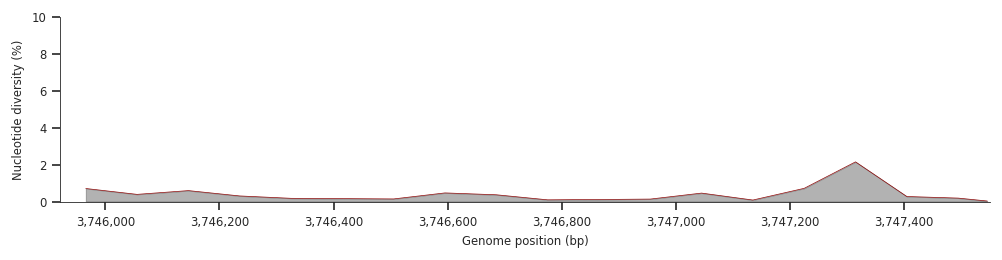

In [ ]:
def plot_diversity_windowed_mean(xlim=hppd_region[1:], ylim=(0, 10), pops=pops, window_size=100, window_step=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2))
        sns.despine(ax=ax, offset=0)

    # plot diversity
    _, windows = allel.windowed_count(pos, size=90, start=xlim[0], stop=xlim[1])
    x = windows.mean(axis=1)
    mpds = np.vstack([allel.mean_pairwise_difference(ac_country[idx]) for idx in pops])
    mpd = np.mean(mpds, axis=0)
    y, _, _ = allel.windowed_statistic(pos_filt, mpd, statistic=lambda v: np.sum(v) / window_size, windows=windows, fill=0)
    ax.fill_between(x, 0, y * 100, color='k', alpha=.3)
    ax.plot(x, y * 100, linestyle='-', marker=None, color='darkred', linewidth=0.4)
    ax.set_ylabel('Nucleotide diversity (%)')
    ax.set_xlabel('Genome position (bp)')

    # tidy up
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])

plot_diversity_windowed_mean()

<ipython-input-75-ad9127b1fd58>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['{:,}'.format(int(v)) for v in ax2.get_xticks()])


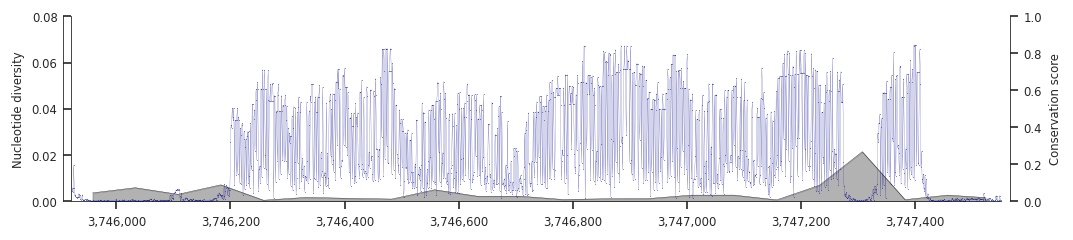

In [ ]:
def plot_diversity(xlim=hppd_region[1:], ac=ac_country, pos=pos_filt, pops=pops, window_size=100, window_step=None, ax=None):
    '''
    This function plot the Nucleotide diversity and conservation score in the same axe.
    '''
    if ax is None:
        fig, ax1 = plt.subplots(figsize=(10, 2))
        sns.despine(ax=ax1, offset=0)
        # plot diversity
        _, windows = allel.windowed_count(pos, size=75, start=xlim[0], stop=xlim[1])
        x = windows.mean(axis=1)
        mpds = np.vstack([allel.mean_pairwise_difference(ac[idx]) for idx in pops])
        mpd = np.mean(mpds, axis=0)
        y, _, _ = allel.windowed_statistic(pos, mpd, statistic=lambda v: np.sum(v) / window_size, windows=windows, fill=0)
        ax1.fill_between(x, 0, np.abs(y) , color='k', alpha=.3, label='Nucleotide diversity')
        ax1.plot(x, np.abs(y), linestyle='-', marker=None, color='k',linewidth=0.2)
        ax1.set_ylabel('Nucleotide diversity')
        ax1.set_ylim(0,0.08)#ax1.set_ylim(0,np.nanmax(y))
        #ax1.set_xlabel('Genome position (bp)')

        # plot cs
        ax2 = ax1.twinx()
        sns.despine(ax=ax2, offset=5, right=False, left=False, bottom=True)
        pl = C_score.query(f'pos > {xlim[0]} and pos < {xlim[1]}')
        #ax2.fill_between(pl.pos, 0, pl.Cs * 100, color='k', alpha=.3)
        ax2.plot(pl.pos, pl.Cs , linestyle='-', linewidth = 0.1, marker='o', markersize=.1,
                 color='darkblue', label='Conservation score')
        ax2.set_ylabel('Conservation score')
        ax2.set_xlabel(f'Chromosome 2L (bp)')
        # tidy up
        #ax2.legend(labels=[])
        ax2.set_xlim(*xlim)
        ax2.set_ylim(0,1)
        ax2.set_xticklabels(['{:,}'.format(int(v)) for v in ax2.get_xticks()])
    else:
        sns.despine(ax=ax, offset=5)
        # plot diversity
        _, windows = allel.windowed_count(pos, size=75, start=xlim[0], stop=xlim[1])
        x = windows.mean(axis=1)
        mpds = np.vstack([allel.mean_pairwise_difference(ac[idx]) for idx in pops])
        mpd = np.mean(mpds, axis=0)
        y, _, _ = allel.windowed_statistic(pos, mpd, statistic=lambda v: np.sum(v) / window_size, windows=windows, fill=0)
        ax.fill_between(x, 0, np.abs(y) , color='k', alpha=.2, label='Nucleotide diversity')
        ax.plot(x, np.abs(y) , linestyle='-', marker=None, color='darkblue', linewidth=0.2)
        ax.set_ylabel('Nucleotide diversity')
        ax.set_ylim(0,0.08)#ax.set_ylim(0,np.nanmax(y))
        #ax.set_xlabel('Genome position (bp)')

        # plot cs
        ax1 = ax.twinx()
        sns.despine(ax=ax1, offset=0, right=False, left=False, bottom=True)
        pl = C_score.query(f'pos > {xlim[0]} and pos < {xlim[1]}')
        #ax2.fill_between(pl.pos, 0, pl.Cs * 100, color='k', alpha=.3)
        ax1.plot(pl.pos, pl.Cs , linestyle='-', linewidth = 0.1, marker='o', markersize=.1,
                 color='darkblue', label='Conservation score')
        ax1.set_ylabel('Conservation score')
        ax1.set_xlabel(f'Chromosome 2L (bp)')
        # tidy up
        ax1.set_xlim(*xlim)
        ax1.set_ylim(0,1)
        ax1.set_xticklabels(['{:,}'.format(int(v)) for v in ax1.get_xticks()])

    # legend
    #fig.legend()


plot_diversity()

In [ ]:
def fig2_density(data = hppd_RA, xlim = hppd_region, window_size=75, window_step=None, pos = pos,
                figsize=(9, 3), exon_label='{}', stop=None, spec_pos=None, legend=True,
                 region_name=None, int_reg=None, int_reg_name='', r1=0.1, r2=1.5, fig_name = None):
    '''
    This function plot the Nucleotide diversity, conservation score, the transcript
    on the same axe.
    '''
    gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(r1, r2))

    fig = plt.figure(figsize=figsize)

    # plot the gene model
    ax = fig.add_subplot(gs[0])
    plot_transcripts(data, ax=ax, xlim=xlim[1:], spec_pos=spec_pos, label_exons=f'{data.index[1]}',
                     region_name=region_name, int_reg=int_reg, int_reg_name=int_reg_name, exon_label=exon_label)
    #plot stop
    if stop:
        if type(stop) == int:
            ax.axvline(x=stop, ymin=0.3, ymax=0.8, color='red', linestyle='--', label='Stop codon')
        else:
            for stop_pos in stop[0:-1]:
                ax.axvline(x=stop_pos, ymin=0.3, ymax=0.8, color='red', linestyle='--')
            ax.axvline(x=stop_pos, ymin=0.3, ymax=0.8, color='red', linestyle='--', label='Stop codon')
    ax.set_xlim(*xlim[1:])

    # plot diversity
    ax = fig.add_subplot(gs[1])
    plot_diversity(xlim=xlim[1:], pops=pops, window_size=window_size, ax=ax)
    ax.set_xlabel(f'Chromosome {xlim[0]} (bp)')

    #legend and layout
    if legend is True:
        fig.legend(bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=6,  frameon=True,  fancybox=True, shadow=False)
    fig.tight_layout()

    #save fig
    if fig_name:
        fig.savefig(f'drive/MyDrive/...../{fig_name}.png', dpi=300, bbox_inches='tight')

<ipython-input-75-ad9127b1fd58>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{:,}'.format(int(v)) for v in ax1.get_xticks()])


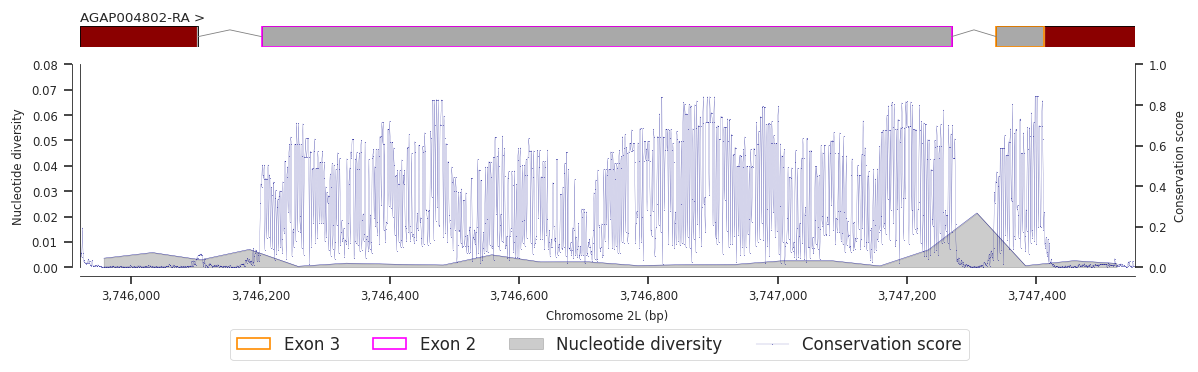

In [ ]:
fig2_density(data=hppd_RA, figsize=(10, 2.8), xlim=hppd_region, pos = pos, window_size=100, exon_label='', legend=True,
             int_reg=Exon_2[1:], int_reg_name='Exon 2', spec_pos=Exon_3[1:], region_name='Exon 3',
             r1=.2, r2=2)